This agent-based model simulates the influence of spatial constraints on network formation, and on SI transmission along the network. _N_ agents with communication range _r_ randomly move through a coordinate grid _gxg_, dynamically add and remove links based on communication range, and with some global probability _P_ diffuse information along these links.

The order of the code is as follows:

1) update rules. The agent behavior at every timestep is defined, both for the ranged model where agents update links based on Euclidean range, and for the non-spatial, randomly connecting null model. Both update rules include an SI diffusion process,

2) run_simulation and subfunctions. A function is defined that runs the update rules for R rounds of T timesteps, and iterates through a chosen range of a chosen input parameter value. This function collects as output 4 network measures at each timestep and averages them per round. It also collects 2 measures describing the SI diffusion process: frequency of I-agents over time and time-to-fixation (timesteps until frequency is 100%). Before this, some subfunctions are defined that are used in the run_simulation function.

3) summary_and_plot. A function is defined that collects summary statistics from the simulation outputs and creates visualizations. Output plots are (1) 2x4 plots where the x-axes are the varying input parameter and the y-axes are the 4 network measures, both for the range and the null model; and (2) 2 plots of the average frequency of I-agents over time, for both the range and null model.

For details on how to use call run_simulation and summary_and_plot to collect simulation results, see "calling the functions" below.

In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import scipy
import seaborn
import pandas

In [ ]:
plt.rcParams.update({'figure.figsize': (10, 10)})
#this just globally sets the figure size

# 1. Update rules

The connect_when_in_range function is the update rule followed by every agent each timestep. The behavior consists of movement, diffusion, and link updating.

To move, each agent chooses from a uniformly random distribution of its adjacent integer coordinates, including its current location. In other words, it selects a tile at random in its Moore neighborhood. To avoid agents sharing the same position, however, tiles currently occupied by other agents are excluded- as are positions out of bounds (below 0 or above _g_). If all tiles are occupied, the agent remains in place. (Note: this means that as _N_ approaches _gxg_, the coordinate space becomes 'saturated,' reaching a state where each agent remains in place, each at a unique coordinate).

To diffuse, each agent is initialized with a "trait" property set to either 1 or 0. Each timestep, all agents with "trait"=1 diffuse to network neighbors with "trait"=0 with probability _P_.

To update links, all agents within Eucldean distance _r_ of each other in the coordinate space create (or keep) links. Previously in-range agents that have moved out of range because of the movement step now cut their ties.

The function assumes as input the graph G (a networkx network object), initialized as empty graph at t=0, or as updated state (output of this function) afterwards. It also takes a value for grid size _g_ such that the coordinate space is _g x g_, communication range _r_ implemented as Euclidian distance, and the diffusion probability _P_.

Agents are updated in a random order each timestep.

In [ ]:
def connect_when_in_range_plus_SI(G, g, Range, P):
    orderlist = random.sample(G.nodes,len(G.nodes))
    #random update order each timestep: take a random sample without replacement of the set of nodes of G,
    #of size N. In other words, arrange the nodes in a random order, which will be used to iterate over this timestep.

    #Movement:
    for i in orderlist:
      #list of positions currently occupied by other agents:
      occupied = list(G.nodes[j]["position"] for j in G.nodes)
      #retreive own current position:
      x, y = G.nodes[i]["position"]
      #Create list of positions in the Moore neighborhood:
      neighborhood = [(x-1,y+1),(x,y+1),(x+1,y+1),(x-1,y),(x,y),(x+1,y),(x-1,y-1),(x,y-1),(x+1,y-1)]
      #Grid boundaries: if any of the available neighborhood positions would be below 0 or above g, delete them from the options:
      for tile in neighborhood:
        if (tile[0] > g) or (tile[0] < 0) or (tile[1] > g) or (tile[1] < 0):
          neighborhood.pop(neighborhood.index(tile))
      #only move if position available (so if the list 'available' is non-empty), otherwise stay at current position:
      available = [pos for pos in neighborhood if pos not in occupied]
      if available:
        G.nodes[i]['position'] = random.choice(available)

    #SI diffusion:
    for i in orderlist:
      for j in G.neighbors(i):
        if G.nodes[i]["trait"] == 1 and G.nodes[j]['trait'] == 0:
          if random.random() < P:
            G.nodes[j]["trait"] = 1
          if G.nodes[j]["trait"] == 1 and G.nodes[i]['trait'] == 0:
            if random.random() < P:
              G.nodes[i]["trait"] = 1

    #Link updating:
    for i in orderlist:
      for j in orderlist:
        if j > i:
          #if within range, create link; if an existing edge is now out of range, remove it.
          ij_distance = math.sqrt((G.nodes[j]["position"][0] - G.nodes[i]["position"][0]) ** 2 +
                                       (G.nodes[j]["position"][1] - G.nodes[i]["position"][1]) ** 2)
          if ij_distance <= Range:
            G.add_edge(i, j)
          elif G.has_edge(i, j):
            G.remove_edge(i, j)

    return G

The intention of theses simulations is to demonstrate the work being done by spatial constraints on communication network formation. In order to do so, the results are compared to a non-spatial model.

In the non-spatial model, instead of moving in a coordinate space, each timestep agents connect to each other agent with probability P (connect) which is set globally as the same for all agents. In other words, the networks are generated by an Erdos-Renyi [source] process for generating random graphs.

For link updating, in order to make the random graph network formation process dynamic and comparable to the range model, there is an additional parameter _P(disconnect)_ which is set to the inverse of _P(connect)_. This mimicks the connection probabilities of the agents in the range model. For randomly moving ranged agents, the probability of connecting to another agent is proportional to the percentage of the total area covered by the communication range. If range covers the whole coordinate space (i.e., for a circular Euclidean range and a square coordinate space, if _(2πr^2) : (g x g) >= 1_, each agent always connect and networks are fully connected, mirroring the _P(connect)=1_ setting. If range does not cover the whole coordinate space, the area not covered by an agent's range is equal to the inverse of the area covered, mirroring the disconnect probability _P(disconnect) = 1 - P(connect)_.

For some thoughts on "comparable" settings between the range and the null model, see "2. Run_simulation", where this function is actually called.

The function takes as input the G_null networkx object graph, 'pc' for P(connect), and P for the diffusion probability.

In [ ]:
def connect_at_random_plus_SI(G_null,pc,P):
  pd = 1-pc
  orderlist = random.sample(G_null.nodes,len(G_null.nodes))

  #Diffusion
  for i in orderlist:
    for j in G_null.neighbors(i):
      if G_null.nodes[i]["trait"] == 1 and G_null.nodes[j]['trait'] == 0:
        if random.random() < P:
          G_null.nodes[j]["trait"] = 1
      if G_null.nodes[j]["trait"] == 1 and G_null.nodes[i]['trait'] == 0:
        if random.random() < P:
          G_null.nodes[i]["trait"] = 1

  #Link updating
  for i in orderlist:
    for j in orderlist:
      if j > i:
        if (not G_null.has_edge(i,j)) and (random.random() < pc):
          #connect if random value between 0 and 1 is lower than the connection chance.
          #At 1 it is always lower, at 0 it never is.
          G_null.add_edge(i, j)
        if G_null.has_edge(i, j) and random.random() < pd:
          G_null.remove_edge(i, j)

  return G_null

# 2. Run_simulation and subfunctions

The following are some functions for operations repeated multiple times in the below run_simulation function.

Collect_stats takes the networks created within a timestep by the above agent behavior functions, and calculates the properties of the networks and diffusion process at that timestep. The properties calculated are, in this order: trait frequency, time to fixation (whether trait frequency has reached 100%), population-average degree, population-average clustering coefficient, whether the graph forms a single connected component, and average shortest path length.

It takes as input parameters the parameter values Q, i, G, and N that will have been declared within the run_simulation function (see below), plus the variables for the statistics this function collects, which will be initialized earlier in the run_simulation function.

In [ ]:
def collect_stats(Q,i,G,N,t,freq_t,fixation_list,degree,clustering,connected_graphs,aspl,freq,count):
  #retrieve trait attributes, and calculate frequency, which = proportion of agents with trait = 1:
  traits = nx.get_node_attributes(G,"trait")
  count = sum(1 for node, trait in traits.items() if trait ==1)
  #If the varying input parameter is N (meaning Q = 1, see below),
  #the population average is taken by dividing by the current iteration value of N
  #(i.e), the current value of i in the 'for i in N' for-loop in the run_simulation function, see below):
  if Q == 1:
    freq = count/i
  #Otherwise, N is constant:
  else:
    freq = count/N
  freq_t.update({t:freq})
  if freq == 1:
    t_fixation = t
    fixation_list.append(t_fixation)

  #Collect network properties
  #Degree:
  list_of_node_degrees = []
  for k in G.nodes:
    list_of_node_degrees.append(G.degree[k])
  #Again, if varying input parameter = N, take the current iteration value of N.
  if Q == 1:
    degree += sum(list_of_node_degrees)/i
  else:
    degree += sum(list_of_node_degrees)/N

  #Clustering:
  #clustering += nx.transitivity(G) is the other possibility; slight difference in how clustering is calculated.
  clustering += nx.average_clustering(G)

  if len(G.nodes) > 0:
  #this condition makes sure we're not calculating connectivity for the null graph at t=0, which will get you an error
    if nx.is_connected(G):
      connected_graphs += 1
      #This is a simple way of calculating ASPL, but requires there to be a single connected component:
      #aspl_G += nx.average_shortest_path_length(G)

  #Smoother way of calculating ASPL: calculate it for each component, then average.
  connected_components = list(nx.connected_components(G))
  avg_lengths = []
  for component in connected_components:
    subgraph = G.subgraph(component)
    avg_lengths.append(nx.average_shortest_path_length(subgraph))
  aspl = sum(avg_lengths) / len(avg_lengths)

  return freq_t, fixation_list, clustering, degree, connected_graphs, aspl

initialize_graph creates N agents and a coordinatespace of g by g. Then, it initializes a networkx empty graph, adds to this graph a "population" of networkx nodes, assigns unique positions to each agent, and 'infects' an initial amount N_init of agents.

It takes as input parameters N,g,N_init, and Q, which are set by calling run_simulation, and i, which is the current iteration index (when initialize_graph is called) of the for-loop over the varying input parameter; see run_simulation.

In [ ]:
def initialize_graph(N,g,N_init,Q,i):
  coordinatespace = [(x,y) for x in range(g) for y in range(g)]

  G = nx.Graph()

  #Again, if varying parameter is N, create i agents rather than N.
  if Q == 1:
    #choose N unique positions as starting positions:
    initpos = random.sample(coordinatespace,i)
    for j in range(i):
      G.add_node(j, position = initpos[j])
      if j < N_init:
        G.nodes[j]["trait"]=1
      else:
        G.nodes[j]["trait"]=0

  #if varying parameter is not N, initialize a graph of size N.
  else:
    initpos = random.sample(coordinatespace,N)
    for n in range(N):
      G.add_node(n, position=initpos[n])
      if n < N_init:
        G.nodes[n]["trait"]=1
      else:
        G.nodes[n]["trait"]=0

  return G

The structure of the output parameters measuring the diffusion process is different from that of the output parameters measuring network measures. The difference is that in the diffusion process outputs, the frequency over time is preserved, rather than averaged over the whole round. Therefore, the trait data needs to be collected seperately, in order for it be called in the right loop; see run_simulation.

In [ ]:
def get_trait_data(i, fixation_list, freq_t, singlerun_fixation,singlerun_freq):
  #only get the first time at which fixation is reached, and only get it if fixation was reached:
  if len(fixation_list) > 0:
    singlerun_fixation.update({i:fixation_list[0]})
  else:
    singlerun_fixation.update({i:"fixation not reached"})
  singlerun_freq.update({i:freq_t})

  return singlerun_fixation, singlerun_freq

Finally, here is the run_simulation function. It's a series of nested for-loops: the first loop 'layer' is over the number of rounds R, the second over the varying input parameter, and the third over the number of timesteps T. All of these are set when calling the run_simulation function; see also "4. Calling the functions."

The varying input paramater is set by the variable 'Q', which is an index value of the list of possible varying parameters [r,N,g,P]. So if Q=0, varying parameter is r; if Q=1, N; etc. The varying parameter will be the "stop" argument in a for-loop which will loop over integer values until reaching the inputted value. The exception is _P_, which doesn't take integer values but values between 0 and 1; hence, if Q is set to 3, the function will instead loop over 10 steps of 0.1 between 0 and 1.

Before looping, the function initializes the 'multirun' dictionaries, which will be the outputs of this function. In the R-loop, the 'singlerun' dictionaries are initialized, which store the outputs of one iteration of r. In the varying parameter loop, the networks are initialized, and the output variables are initialized that will represent the time-averaged network measures of one iteration over 100 timesteps. Finally, in the T-loop, the range and null model update rules are executed, and the network measures at t collected. Then, outside of the T-loop again, these collected measures are averaged (except for connectedness, which is not an average but a simple count) and put into the singlerun dictionaries as an entry {i:measure value}, where i is the current value of the varying input parameter. Finally, outside of the varying parameter loop but still inside the R-loop, the multirun dictionaries are updated with an entry {R:singlerun entry}. The final multirun dictionaries that are returned by this function, then, will have R entries of the form {R:{i:{network measure average value}}; except for the trait frequency dictionary, which preserves frequency over time, and has the structure {R:{i{t:trait frequency}}}.

As to which settings the null model takes: if Q=0 so r is the varying parameter, the analagous parameter is p(connect). This will simply go through 10 steps between 0 and 1 (the complete meaningful range of p(connect)).   Otherwise, it's set so that p(connect) = r:g. For example, if r=2 and g=10, pc = 0.2. This match isn't completely exact, but gives comparable behavior. If Q=2 and so the varying parameter is _g_, no null model data is collected, because there is no null analogue to _g_. At Q=1 and Q=3, the parameters can simply be the same; the null model also contains N and P.

In [ ]:
def run_simulation(R,r,N,g,T,P,N_init,Q):
  #Note version 02/05/2024: there are still some commented print commands in here in order to troubleshoot why varying N does not work as expected.
  #Initialize the output dictionaries: will have the form {round number:{"singlerun" dict}} (see below for "singlerun" dicts).
  multirun_freq = {}
  multirun_fixation = {}

  multirun_degree = {}
  multirun_clustering = {}
  multirun_connectedness = {}
  multirun_aspl = {}

  null_multirun_freq = {}
  null_multirun_fixation = {}

  null_multirun_degree = {}
  null_multirun_clustering = {}
  null_multirun_connectedness = {}
  null_multirun_aspl = {}

  #Q is a parameter that determines which input parameter is the varying parameter for the current simulation run.
  #It's an index value of the list of possible varying parameters [r,N,g,P].

  if Q == 3:
    #If the varying parameter is P, a value between 0 and 1, the loop will be over 10 decimal values
    #at equal intervals, which is done by the linspace function. Usually P=1, so values will be [0.1,0.2,0.3....0.9,1.0].
    #Otherwise, 10 decimal values are still found (and the round((),1) command ensures there's still just one decimal).
    #(But note that P>1 doesn't make much sense).
    varying_parameter = list(np.round(np.linspace(0,P,11),1))
  else:
    varying_parameter = list(range([r,N,g,P][Q]))

  for round_number in range(R):
    #Initialize the output dictionaries of a single simulation round: 100 timesteps at a constant input parameter value.
    # Will have the form {parameter value:time-average network measure} (except in the case of connectedness, which is not a time-average but a count out of the 100 timesteps.)
    singlerun_degree = {}
    singlerun_clustering = {}
    singlerun_connectedness = {}
    singlerun_aspl = {}

    singlerun_freq = {}
    singlerun_fixation = {}

    null_singlerun_degree = {}
    null_singlerun_clustering = {}
    null_singlerun_connectedness = {}
    null_singlerun_aspl = {}

    null_singlerun_freq = {}
    null_singlerun_fixation = {}

    for i in varying_parameter:
      #Skip the N=0 iteration, which just means empty graphs:
      if Q == 1 and i == 0:
        continue
      #Initialize the variables storing the output parameter values at single timesteps.
      degree = 0
      clustering = 0
      connected_graphs = 0
      aspl = 0

      freq = 0
      count = 0
      freq_t ={}

      t_fixation = 0
      fixation_list = []

      null_degree = 0
      null_clustering = 0
      null_connected_graphs = 0
      null_aspl = 0

      null_freq = 0
      null_count = 0
      null_freq_t ={}

      null_t_fixation = 0
      null_fixation_list = []

      #t=0: initialize G as graph of N nodes with position and trait attributes; N_init nodes starting with trait = 1.
      G = initialize_graph(N,g,N_init,Q,i)

      #Also initialize G_null: much simpler, does not have positions or coordinate space.
      G_null = nx.Graph()
      if Q ==1:
        for j in range(i):
          G_null.add_node(j)
          if j < N_init:
            G_null.nodes[j]["trait"]=1
          else:
            G_null.nodes[j]["trait"]=0
      else:
        for n in range(N):
          G_null.add_node(n)
          if n < N_init:
            G_null.nodes[n]["trait"]=1
          else:
            G_null.nodes[n]["trait"]=0

      for t in range(T):
        #Depending on the chosen Q-value, one of the model parameters is varied from 0 up to that value.
        #A null model is run alongside it, at matching settings.
        if Q == 0:
          G = connect_when_in_range_plus_SI(G, g, i, P)
          if i <= 10: #note this solution assumes i will always be integer values.
            pc = list(np.round(np.linspace(0,1,11),1))[i]
            G_null = connect_at_random_plus_SI(G_null,pc,P)
        elif Q == 1:
          #In the varying N runs, N varies based on the above initialization of G and G_null.
          G = connect_when_in_range_plus_SI(G, g, r, P)
          G_null = connect_at_random_plus_SI(G_null,r/g,P)
        elif Q == 2:
          G = connect_when_in_range_plus_SI(G, i, r, P)
          #no comparable null model here
        elif Q == 3:
          G = connect_when_in_range_plus_SI(G, g, r, i)
          G_null = connect_at_random_plus_SI(G_null,r/g,i)

        freq_t, fixation_list, clustering, degree, connected_graphs, aspl = collect_stats(Q,i,G,N,t,freq_t,fixation_list,degree,clustering,connected_graphs,aspl,freq,count)

        #print(f'degree:{degree}')

        if Q != 2:
        #don't collect null stats if g is varying; no corresponding null model.
          null_freq_t, null_fixation_list, null_clustering, null_degree, null_connected_graphs, null_aspl = collect_stats(Q,i,G_null,N,t,null_freq_t,null_fixation_list,null_degree,null_clustering,null_connected_graphs,null_aspl,null_freq,null_count)

          #print(f'nulldegree:{null_degree}')

      singlerun_fixation, singlerun_freq = get_trait_data(i, fixation_list, freq_t, singlerun_fixation,singlerun_freq)

      #print(f'fix, freq: {singlerun_fixation,singlerun_freq}')

      if Q != 2:
        if Q == 0:
          #When the varying parameter is range, the null model parameter is pc, which is always varied between 0 and 1.
          if i <= 10:
            pc = list(np.round(np.linspace(0,1,11),1))[i] #note this solution does assume that i is always an integer.
            null_singlerun_fixation, null_singlerun_freq = get_trait_data(pc, null_fixation_list, null_freq_t, null_singlerun_fixation, null_singlerun_freq)

            #print(f'nullfix, nullfreq, pc: {null_singlerun_fixation,null_singlerun_freq}')

        else:
          null_singlerun_fixation, null_singlerun_freq = get_trait_data(i, null_fixation_list, null_freq_t, null_singlerun_fixation, null_singlerun_freq)

          #print(f'nullfix, nullfreq, N: {null_singlerun_fixation,null_singlerun_freq}')

      #In collect_stats, single-timestep values have been summed throughout a full round of 100 timesteps, and to get a time-average they are here divided by T.

      #print(f'degree, total:{degree}')

      singlerun_degree.update({i:[degree/T]})
      singlerun_clustering.update({i: [clustering/T]})
      singlerun_connectedness.update({i:[connected_graphs]})
      singlerun_aspl.update({i:[aspl/T]})

      #print(f'degree, average: {singlerun_degree}')

      if Q != 2:
      #Again, don't collect null data when input parameter is g.
        if Q == 0:
          if i <= 10:
            #print(f'nulldegree, pc,total:{null_degree}')
            pc = list(np.round(np.linspace(0,1,11),1))[i]
            null_singlerun_degree.update({pc:[null_degree/T]})
            null_singlerun_clustering.update({pc: [null_clustering/T]})
            null_singlerun_connectedness.update({pc:[null_connected_graphs]})
            null_singlerun_aspl.update({pc:[null_aspl/T]})

            #print(f'nulldegree, pc: {null_singlerun_degree}')

        else:
          #print(f'nulldegree,N,total:{null_degree}')
          null_singlerun_degree.update({i:[null_degree/T]})
          null_singlerun_clustering.update({i: [null_clustering/T]})
          null_singlerun_connectedness.update({i:[null_connected_graphs]})
          null_singlerun_aspl.update({i:[null_aspl/T]})

          #print(f'nulldegree, N,avg: {null_singlerun_degree}')

    multirun_degree.update({round_number:singlerun_degree})
    multirun_clustering.update({round_number:singlerun_clustering})
    multirun_connectedness.update({round_number:singlerun_connectedness})
    multirun_aspl.update({round_number:singlerun_aspl})

    multirun_fixation.update({round_number:singlerun_fixation})
    multirun_freq.update({round_number:singlerun_freq})

    if Q != 2:
      null_multirun_degree.update({round_number:null_singlerun_degree})
      null_multirun_clustering.update({round_number:null_singlerun_clustering})
      null_multirun_connectedness.update({round_number:null_singlerun_connectedness})
      null_multirun_aspl.update({round_number:null_singlerun_aspl})

      null_multirun_fixation.update({round_number:null_singlerun_fixation})
      null_multirun_freq.update({round_number:null_singlerun_freq})

  return(multirun_freq, multirun_fixation,multirun_degree,multirun_clustering,multirun_connectedness,multirun_aspl,
         null_multirun_freq, null_multirun_fixation, null_multirun_degree, null_multirun_clustering, null_multirun_connectedness,null_multirun_aspl)
  #Note: if g is varying, null dictionaries will simply return empty.


# 3. Summary_and_plot

The final function takes the output dictionaries created by calling run_simulation, and creates visualizations and summaries of that output.



create_plot is a subfunction used to generate the network properties (y-axis) vs. input parameter (x-axis) plots. First, a scatterplot is created in which points are results for single rounds (as explained above, these are time-averaged network properties over T timesteps, except for connectivity which is a simple count). If R=100, each input parameter value on the x axis will have 100 results. Second, a trend line is drawn connecting the averages across these R single-round measures. Third, a transparent area is created corresponding to 1.5 standard deviations around this average.
The function takes as input:

-index number of the current subplot (a matplotlib object of 4 subplots axes[0] through axes [4] is created in summary_and_plot);

-the input argument of summary_and_plot "parameter_label", which records the variable that was varied in the run_simulation call;

-"round_number", the current value of the for-loop over rounds inside of which create_plot will be called in summary_and_plot;

-"title" and "param_values" which are also input arguments of summary_and_plot;

-the relevant output dictionary of run_simulation;

-the relavant summary statistics created earlier in the summary_and_plot function.

In [ ]:
def create_plot(index,axes,parameter_label,round_number,title,param_values,multirundict,round_average,round_sd):
  axes[index].set_title(f"{parameter_label} vs. {title}")
  for round_number in range(len(multirundict)):
      x_values = param_values
      y_values = [multirundict[round_number][value][0] for value in param_values]
      #Scatterplot of round average results of network properties:
      axes[index].scatter(x_values, y_values, color='cornflowerblue', alpha=0.3, s=2)

  #Plotting network property outcomes:
  axes[index].plot(param_values, list(round_average.values()), color='blue', label='Average Degree')
  axes[index].fill_between(param_values, np.array(list(round_average.values())) - 1.5 * np.array(list(round_sd.values())),
                         np.array(list(round_average.values())) + 1.5 * np.array(list(round_sd.values())), color='lightsteelblue', alpha=0.3)

  axes[index].set_xlabel(parameter_label)
  axes[index].set_ylabel(f'{title}')
  #axes[index].legend()

  return axes[index]

summary_and_plot unpacks the results from run_simulation in another series of nested for-loops (simply to reformat the {R:{i{value}} dictionaries to {i{R:{value}} dictionaries), and creates plots of the network and diffusion process measures.

The diffusion process results are plotted with time on x-axis and trait frequency on the y axis. Lines are drawn for each input parameter value that was varied in the simulation, of the average frequency at each timestep.

The function takes as input variables:

-the results dictionaries from run_simulation;

-"title", a string describing the plotted results;

-"parameter_label", a string describing the input parameter variable that was used in the simulation run;

-"param_values": this is a list of all the values that were taken by the varying input parameter.

In [ ]:
def summary_and_plot(results,title,parameter_label,param_values,print_summary=True):
  multirun_freq, multirun_fixation,multirun_degree,multirun_clustering,multirun_connectedness,multirun_aspl,null_multirun_freq, null_multirun_fixation, null_multirun_degree, null_multirun_clustering, null_multirun_connectedness,null_multirun_aspl = results

  #intialize summary statistics:
  averages_per_value = {}
  sd_per_value = {}
  min_per_value = {}
  max_per_value = {}

  round_average_deg = {}
  round_sd_deg = {}
  round_min_deg = {}
  round_max_deg = {}

  round_average_cc = {}
  round_sd_cc = {}
  round_min_cc = {}
  round_max_cc = {}

  round_average_conn = {}
  round_sd_conn = {}
  round_min_conn = {}
  round_max_conn = {}

  round_average_aspl = {}
  round_sd_aspl = {}
  round_min_aspl = {}
  round_max_aspl = {}

  null_averages_per_value = {}
  null_sd_per_value = {}
  null_min_per_value = {}
  null_max_per_value = {}

  null_round_average_deg = {}
  null_round_sd_deg = {}
  null_round_min_deg = {}
  null_round_max_deg = {}

  null_round_average_cc = {}
  null_round_sd_cc = {}
  null_round_min_cc = {}
  null_round_max_cc = {}

  null_round_average_conn = {}
  null_round_sd_conn = {}
  null_round_min_conn = {}
  null_round_max_conn = {}

  null_round_average_aspl = {}
  null_round_sd_aspl = {}
  null_round_min_aspl = {}
  null_round_max_aspl = {}

  for value in param_values:
    #again, if range is the varying variable, the null model varies pc between 0 and 1.
    if parameter_label == 'Range':
      if value <=10:
        nullvalue = list(np.round(np.linspace(0,1,11),1))[value]
    else:
      nullvalue = value
    #again, skip the N = 0 iteration:
    if parameter_label == 'N' and value == 0:
      continue

    #initialize the network measure objects:
    average_t_r = {}
    sd_t_r ={}
    min_t_r={}
    max_t_r={}

    degree_values = []
    clustering_values = []
    connectedness_values = []
    aspl_values = []

    null_average_t_r = {}
    null_sd_t_r ={}
    null_min_t_r={}
    null_max_t_r={}

    null_degree_values = []
    null_clustering_values = []
    null_connectedness_values = []
    null_aspl_values = []

    #For the network property vs. input parameter graphs, retrieve the round-average values (y in the plots) at the current parameter value (x in the plots).
    for round_number in range(len(multirun_degree)):
      degree_values.append(multirun_degree[round_number][value][0])
      clustering_values.append(multirun_clustering[round_number][value][0])
      connectedness_values.append(multirun_connectedness[round_number][value][0])
      aspl_values.append(multirun_aspl[round_number][value][0])

      #Don't try to retrieve null results when g is the input parameter, because there isn't any
      if parameter_label != 'g':

        null_degree_values.append(null_multirun_degree[round_number][nullvalue][0])
        null_clustering_values.append(null_multirun_clustering[round_number][nullvalue][0])
        null_connectedness_values.append(null_multirun_connectedness[round_number][nullvalue][0])
        null_aspl_values.append(null_multirun_aspl[round_number][nullvalue][0])

    #For each parameter value, calculate statistics over the 100 runs done at that parameter value.
    round_average_deg[value] = np.mean(degree_values)
    round_sd_deg[value] = np.std(degree_values)
    round_min_deg[value] = np.min(degree_values)
    round_max_deg[value] = np.max(degree_values)

    round_average_cc[value] = np.mean(clustering_values)
    round_sd_cc[value] = np.std(clustering_values)
    round_min_cc[value] = np.min(clustering_values)
    round_max_cc[value] = np.max(clustering_values)

    round_average_conn[value] = np.mean(connectedness_values)
    round_sd_conn[value] = np.std(connectedness_values)
    round_min_conn[value] = np.min(connectedness_values)
    round_max_conn[value] = np.max(connectedness_values)

    round_average_aspl[value] = np.mean(aspl_values)
    round_sd_aspl[value] = np.std(aspl_values)
    round_min_aspl[value] = np.min(aspl_values)
    round_max_aspl[value] = np.max(aspl_values)

    if parameter_label != 'g':

      null_round_average_deg[nullvalue] = np.mean(null_degree_values)
      null_round_sd_deg[nullvalue] = np.std(null_degree_values)
      null_round_min_deg[nullvalue] = np.min(null_degree_values)
      null_round_max_deg[nullvalue] = np.max(null_degree_values)

      null_round_average_cc[nullvalue] = np.mean(null_clustering_values)
      null_round_sd_cc[nullvalue] = np.std(null_clustering_values)
      null_round_min_cc[nullvalue] = np.min(null_clustering_values)
      null_round_max_cc[nullvalue] = np.max(null_clustering_values)

      null_round_average_conn[nullvalue] = np.mean(null_connectedness_values)
      null_round_sd_conn[nullvalue] = np.std(null_connectedness_values)
      null_round_min_conn[nullvalue] = np.min(null_connectedness_values)
      null_round_max_conn[nullvalue] = np.max(null_connectedness_values)

      null_round_average_aspl[nullvalue] = np.mean(null_aspl_values)
      null_round_sd_aspl[nullvalue] = np.std(null_aspl_values)
      null_round_min_aspl[nullvalue] = np.min(null_aspl_values)
      null_round_max_aspl[nullvalue] = np.max(null_aspl_values)

  #Plots of input parameters(x) versus network structure outcomes (y):

  # Create four subplots side by side
  fig, axes = plt.subplots(1, 4, figsize=(20, 5))

  axes[0] = create_plot(0,axes,parameter_label,round_number,'Average degree',param_values,multirun_degree,
              round_average_deg,round_sd_deg)

  axes[1] = create_plot(1,axes,parameter_label,round_number,'Clustering coefficient',param_values,multirun_clustering,
              round_average_cc,round_sd_cc)

  axes[2] = create_plot(2,axes,parameter_label,round_number,'Connected graphs',param_values,multirun_connectedness,
              round_average_conn,round_sd_conn)

  axes[3] = create_plot(3,axes,parameter_label,round_number,'Average shortest path length',param_values,multirun_aspl,
              round_average_aspl,round_sd_aspl)

  plt.tight_layout()
  plt.show()

  if parameter_label != 'g':

  # Create four subplots for the corresponding null runs
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    if parameter_label == 'Range':
      null_label = 'P(connect)'
      null_param_values = list(np.round(np.linspace(0,1,11),1))
    else:
      null_label = parameter_label
      null_param_values = param_values

    #In the other cases, N and P, the label is the same in the null runs. In the g case, no null models are generated.


    axes[0] = create_plot(0,axes,null_label,round_number,'Average degree',null_param_values,null_multirun_degree,
                          null_round_average_deg,null_round_sd_deg)

    axes[1] = create_plot(1,axes,null_label,round_number,'Clustering coefficient',null_param_values,null_multirun_clustering,
                          null_round_average_cc,null_round_sd_cc)

    axes[2] = create_plot(2,axes,null_label,round_number,'Connected graphs',null_param_values,null_multirun_connectedness,
                          null_round_average_conn,null_round_sd_conn)

    axes[3] = create_plot(3,axes,null_label,round_number,'Average shortest path length',null_param_values,null_multirun_aspl,
                          null_round_average_aspl,null_round_sd_aspl)

    plt.tight_layout()
    plt.show()


  #Diffusion over time graphs:

  fig,axes = plt.subplots(1,2,figsize = (20,5))

  t_values = len(multirun_freq[5][5].keys())
  R_values = len(multirun_degree)
  #nothing special about this dictionary or the indexes, just want to retrieve the number of rounds

  #First plot, time on x, varying input parameter on y:

  for value in param_values:
    average_t_r = {}
    sd_t_r ={}
    min_t_r={}
    max_t_r={}

    for t in range(t_values):
      yparam_value_list = []

      for round_number in range(R_values):
        #at the following line it's giving me a keyerror: 2. Why?
        yparam_value_at_t = multirun_freq[round_number][value][t]

        #in the dictionary tracking the trait frequency at each timestep, retrieve that frequency at
        #the current parameter value, round and timestep.
        yparam_value_list.append(yparam_value_at_t)

      average_at_t = np.mean(yparam_value_list)
      sd_at_t = np.std(yparam_value_list)
      min_value_at_t = min(yparam_value_list)
      max_value_at_t = max(yparam_value_list)

      average_t_r.update({t:average_at_t})
      sd_t_r.update({t:sd_at_t})
      min_t_r.update({t:min_value_at_t})
      max_t_r.update({t:max_value_at_t})

    averages_per_value.update({value:average_t_r})
    sd_per_value.update({value:sd_t_r})
    min_per_value.update({value:min_t_r})
    max_per_value.update({value:max_t_r})

    xlist = [t for t in range(t_values)]
    ylist = []
    for t in range(t_values):
      #because this is is also how many y-values were taken
      ylist.append(averages_per_value[value][t])
    axes[0].plot(xlist,ylist,label=f'{parameter_label}= {value}')
    axes[0].set_xlabel('Timestep')
    axes[0].set_ylabel('Trait frequency')
    axes[0].set_title('Diffusion over time')
    axes[0].legend()

  #Second plot, null run:

  if parameter_label != 'g':

    if parameter_label =="Range":
      looplist = list(np.round(np.linspace(0,1,11),1))
    else:
      looplist = list(range(len(param_values)))

    for value in looplist:
      null_average_t_r = {}
      null_sd_t_r ={}
      null_min_t_r={}
      null_max_t_r={}

      for t in range(t_values):
        null_yparam_value_list = []

        for round_number in range(R_values):
          if parameter_label == 'N' and value == 0:
            continue
          null_yparam_value_at_t = null_multirun_freq[round_number][value][t]
          #in the dictionary tracking the trait frequency at each timestep, retrieve that frequency at
          #the current parameter value, round and timestep.
          null_yparam_value_list.append(null_yparam_value_at_t)

          null_average_at_t = np.mean(null_yparam_value_list)
          null_sd_at_t = np.std(null_yparam_value_list)
          null_min_value_at_t = min(null_yparam_value_list)
          null_max_value_at_t = max(null_yparam_value_list)

          null_average_t_r.update({t:null_average_at_t})
          null_sd_t_r.update({t:null_sd_at_t})
          null_min_t_r.update({t:null_min_value_at_t})
          null_max_t_r.update({t:null_max_value_at_t})

        null_averages_per_value.update({value:null_average_t_r})
        null_sd_per_value.update({value:null_sd_t_r})
        null_min_per_value.update({value:null_min_t_r})
        null_max_per_value.update({value:null_max_t_r})

      null_averages_per_value.update({value:null_average_t_r})
      null_sd_per_value.update({value:null_sd_t_r})
      null_min_per_value.update({value:null_min_t_r})
      null_max_per_value.update({value:null_max_t_r})

      xlist = [t for t in range(t_values)]
      ylist = []
      for t in range(t_values):
        if parameter_label == 'N' and value == 0:
          continue
        #because this is is also how many y-values were taken
        ylist.append(null_averages_per_value[value][t])
      if parameter_label == 'Range':
        parameter_label = 'P(connect)'
      axes[1].plot(xlist,ylist,label=f'{parameter_label}={value}')
      axes[1].set_xlabel('Timestep')
      axes[1].set_ylabel('Trait frequency')
      axes[1].set_title('Diffusion over time: null model')
      axes[1].legend()

    plt.tight_layout()
    plt.show()


  #Print summary statistics:
  #  if print_summary:
   #   for t in range(t_values):
   #     meanval = averages_per_value[value][t]
   #     minval = min_per_value[value][t]
   #     maxval = max_per_value[value][t]
   #     sd = sd_per_value[value][t]
   #     fixation = results[1][round_number][value]
   #     print(f"{parameter_label} = {value}, t={t} Average={meanval}, Min={minval}, Max={maxval}, SD={sd}, fixation time={fixation}")

  if print_summary:
    print("Summary for Degree:")
    for value in param_values:
      print(f"{parameter_label} = {value}:")
      print("Degree - Averages:", round_average_deg[value])
      print("Degree - SD:", round_sd_deg[value])
      print("Degree - Min:", round_min_deg[value])
      print("Degree - Max:", round_max_deg[value])

    print("\nSummary for Clustering:")
    for value in param_values:
      print(f"{parameter_label} = {value}:")
      print("Clustering - Averages:", round_average_cc[value])
      print("Clustering - SD:", round_sd_cc[value])
      print("Clustering - Min:", round_min_cc[value])
      print("Clustering - Max:", round_max_cc[value])

    print("\nSummary for Connectedness:")
    for value in param_values:
      print(f"{parameter_label} = {value}:")
      print("Connectedness - Averages:", round_average_conn[value])
      print("Connectedness - SD:", round_sd_conn[value])
      print("Connectedness - Min:", round_min_conn[value])
      print("Connectedness - Max:", round_max_conn[value])

    print("\nSummary for Average shortest path length:")
    for value in param_values:
      print(f"{parameter_label} = {value}:")
      print("Aspl - Averages:", round_average_aspl[value])
      print("Aspl - SD:", round_sd_aspl[value])
      print("Aspl - Min:", round_min_aspl[value])
      print("Aspl - Max:", round_max_aspl[value])

    if parameter_label != 'g':

      print("Summary for Degree, null:")
      for value in null_param_values:
        print(f"{null_label} = {value}:")
        print("Degree - Averages:", null_round_average_deg[value])
        print("Degree - SD:", null_round_sd_deg[value])
        print("Degree - Min:", null_round_min_deg[value])
        print("Degree - Max:", null_round_max_deg[value])

      print("\nSummary for Clustering, null:")
      for value in null_param_values:
        print(f"{null_label} = {value}:")
        print("Clustering - Averages:", null_round_average_cc[value])
        print("Clustering - SD:", null_round_sd_cc[value])
        print("Clustering - Min:", null_round_min_cc[value])
        print("Clustering - Max:", null_round_max_cc[value])

      print("\nSummary for Connectedness, null:")
      for value in null_param_values:
        print(f"{null_label} = {value}:")
        print("Connectedness - Averages:", null_round_average_conn[value])
        print("Connectedness - SD:", null_round_sd_conn[value])
        print("Connectedness - Min:", null_round_min_conn[value])
        print("Connectedness - Max:", null_round_max_conn[value])

      print("\nSummary for Average shortest path length, null:")
      for value in null_param_values:
        print(f"{null_label} = {value}:")
        print("Aspl - Averages:", null_round_average_aspl[value])
        print("Aspl - SD:", null_round_sd_aspl[value])
        print("Aspl - Min:", null_round_min_aspl[value])
        print("Aspl - Max:", null_round_max_aspl[value])



# 4. Calling the functions

To run the simulation, call the run_simulation function. As a reminder, the arguments of run_simulation are: (R,r,N,g,T,P,N_init,Q). Choose an input parameter (r,N,g,P) to be varied. Input the corresponding value for Q: varying_parameter = list(range([r,N,g,P][Q])). Then, for the varying parameter, put the maximum value. For all other values, put a constant value.

For example, for varying range between 0 and 20, and R=100,N=10,g=10,T=100,N_init = 1:

In [ ]:
data = run_simulation(100,20,10,10,100,0.05,1,0)

To plot the results, call the summary_and_plot function. The arguments are (results,title,parameter_label,param_values,print_summary=True). For results, simply put the object you just defined in the run_simulation call. For title, you can create a description of the output plots; i usually put "Average network properties of communication and transmission graph under varying [varying parameter]." For parameter_label, put the name of the varying input parameter chosen in the simulation run: "Range","N","g",or "P". For param_values, create a list of which the entries correspond to the values taken by the varying parameter. For P, this is list(round(np.linspace(0,11,1),1)); for the other parameters, it's list(range([chosen maximum value])).

For example, for range varying between 0 and 20:

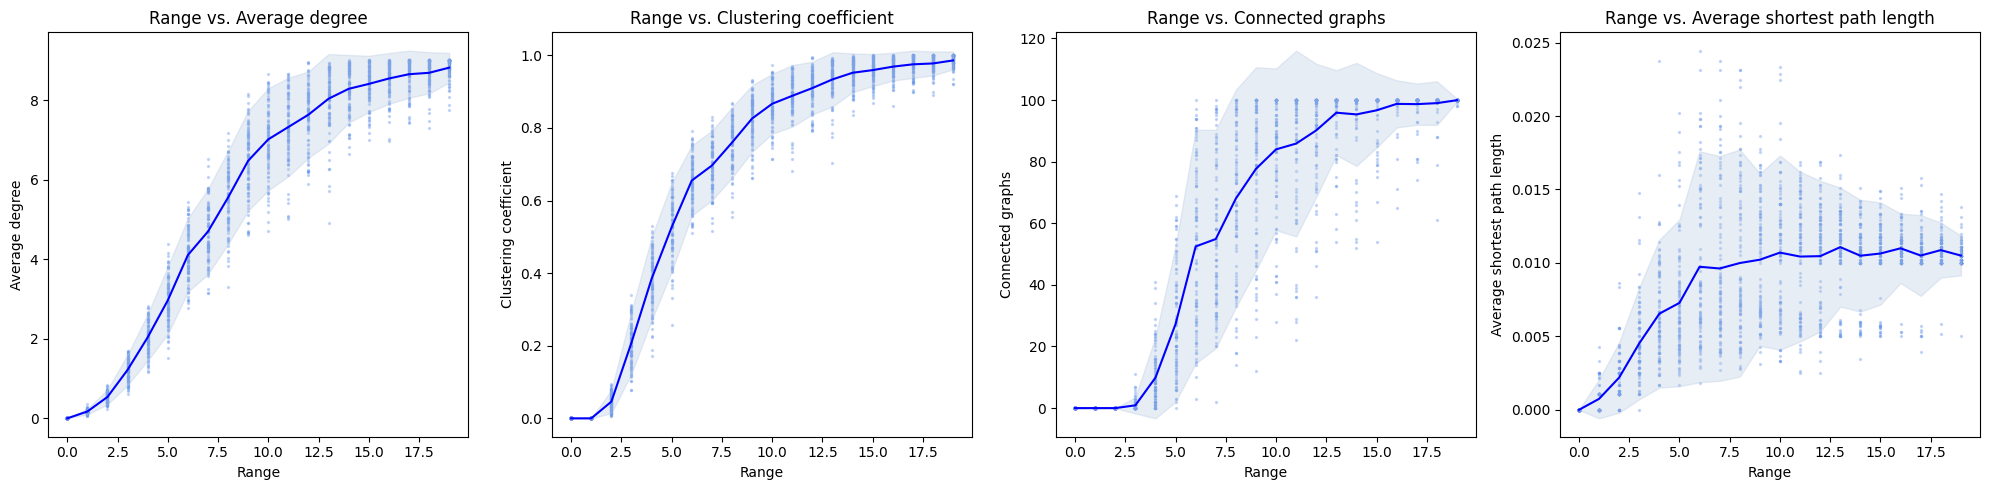

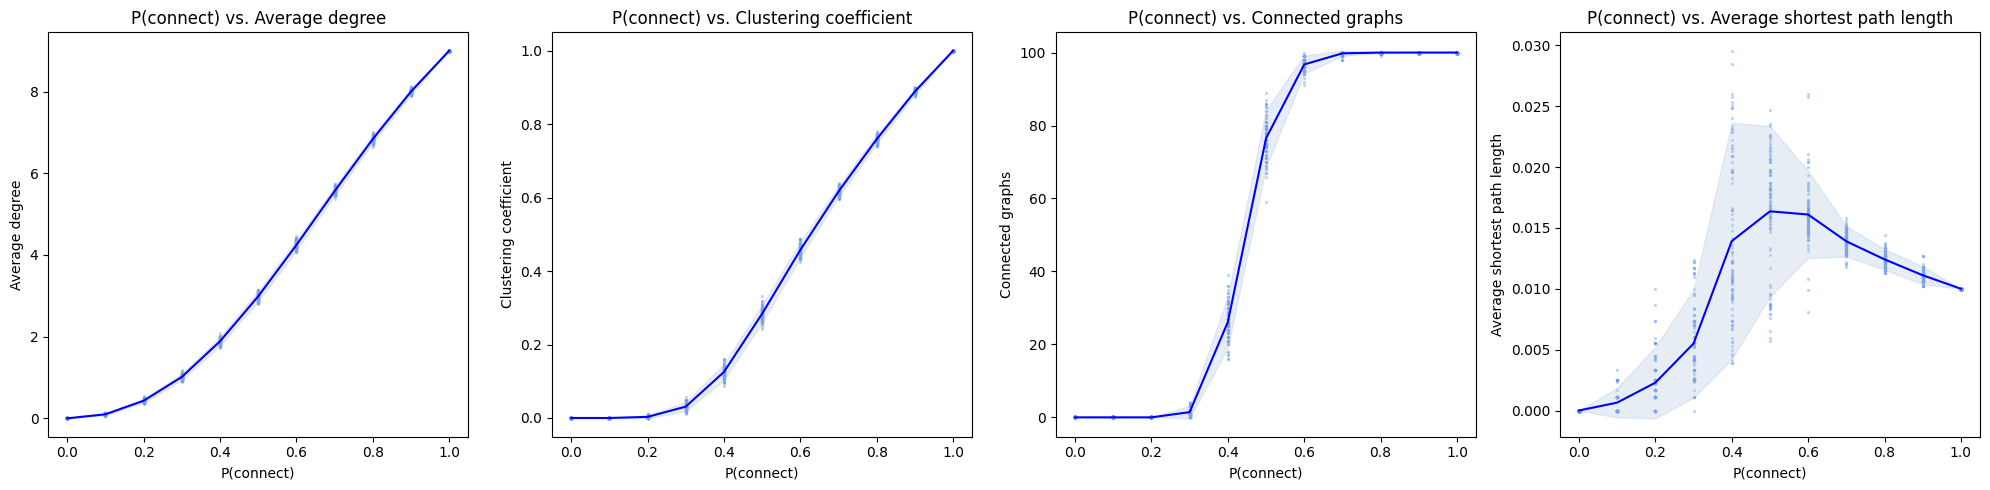

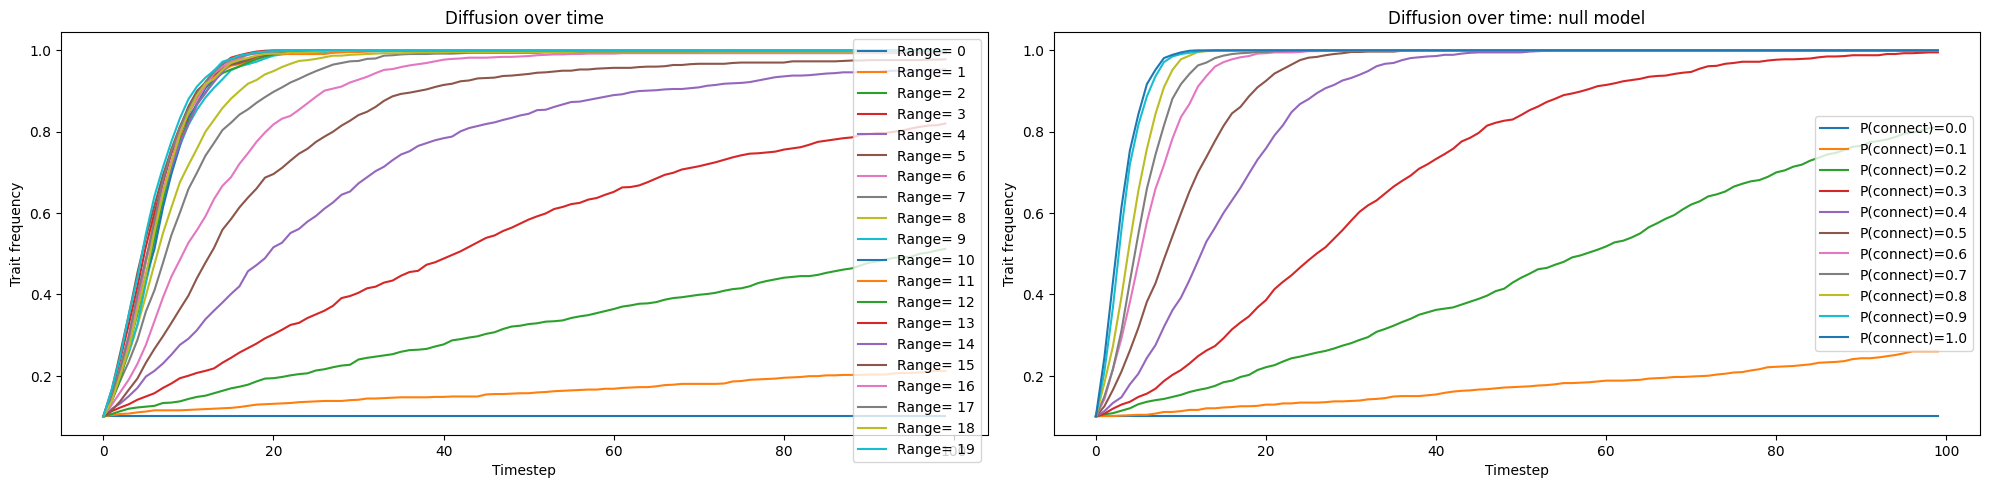

Summary for Degree:
P(connect) = 0:
Degree - Averages: 0.0
Degree - SD: 0.0
Degree - Min: 0.0
Degree - Max: 0.0
P(connect) = 1:
Degree - Averages: 0.17185999999999982
Degree - SD: 0.04774453267129122
Degree - Min: 0.06200000000000003
Degree - Max: 0.35600000000000004
P(connect) = 2:
Degree - Averages: 0.5369600000000001
Degree - SD: 0.1238872003073764
Degree - Min: 0.24599999999999966
Degree - Max: 0.8419999999999997
P(connect) = 3:
Degree - Averages: 1.2174799999999997
Degree - SD: 0.2556281080006657
Degree - Min: 0.618
Degree - Max: 1.7039999999999993
P(connect) = 4:
Degree - Averages: 2.03576
Degree - SD: 0.3876283044360926
Degree - Min: 1.1579999999999995
Degree - Max: 2.811999999999998
P(connect) = 5:
Degree - Averages: 2.96474
Degree - SD: 0.5652633124482784
Degree - Min: 1.5199999999999987
Degree - Max: 4.3759999999999994
P(connect) = 6:
Degree - Averages: 4.103020000000001
Degree - SD: 0.6150667927957094
Degree - Min: 2.764
Degree - Max: 5.438
P(connect) = 7:
Degree - Averages:

In [ ]:
summary_and_plot(data,'Average network properties of communication and transmission graphs under varying communication range','Range',list(range(20)))

In [ ]:
dataN = run_simulation(100,2,10,10,100,0.05,1,1)

<ipython-input-22-41bfa4438b38>:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  orderlist = random.sample(G.nodes,len(G.nodes))
<ipython-input-23-86718ab6ba21>:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  orderlist = random.sample(G_null.nodes,len(G_null.nodes))


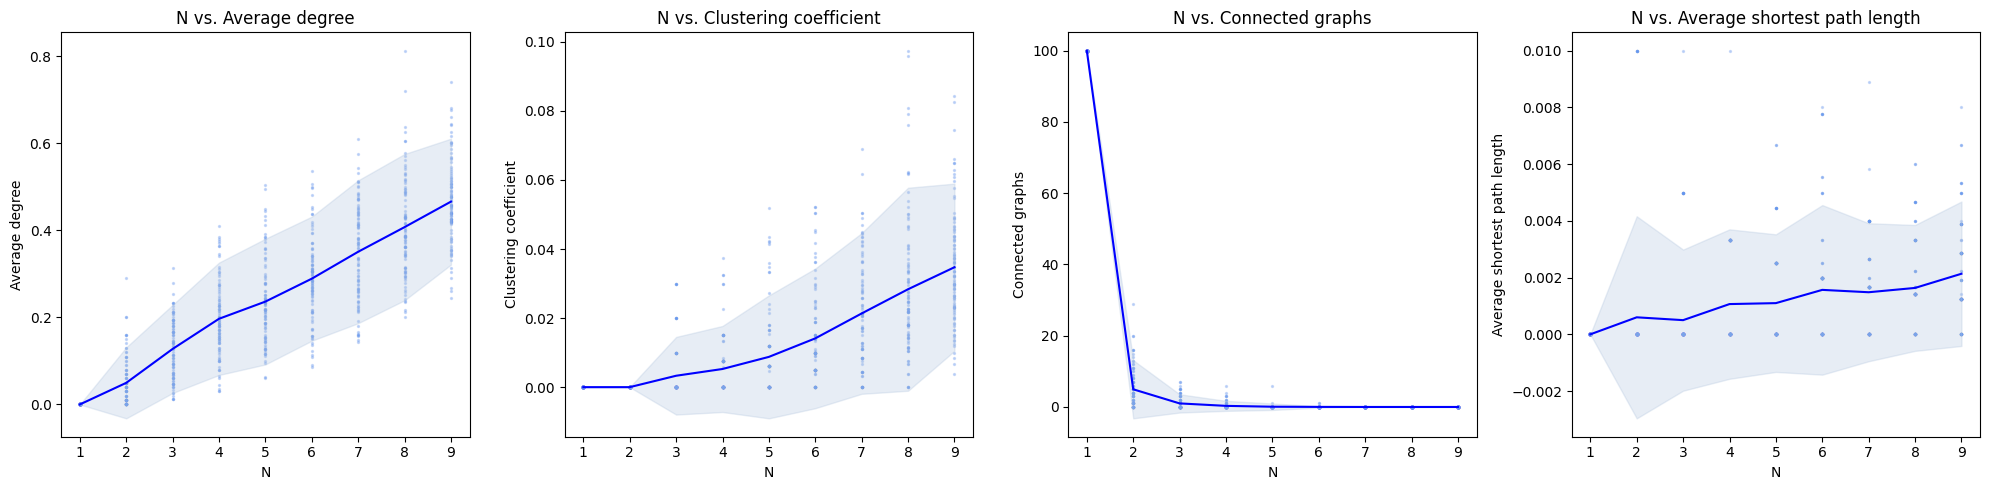

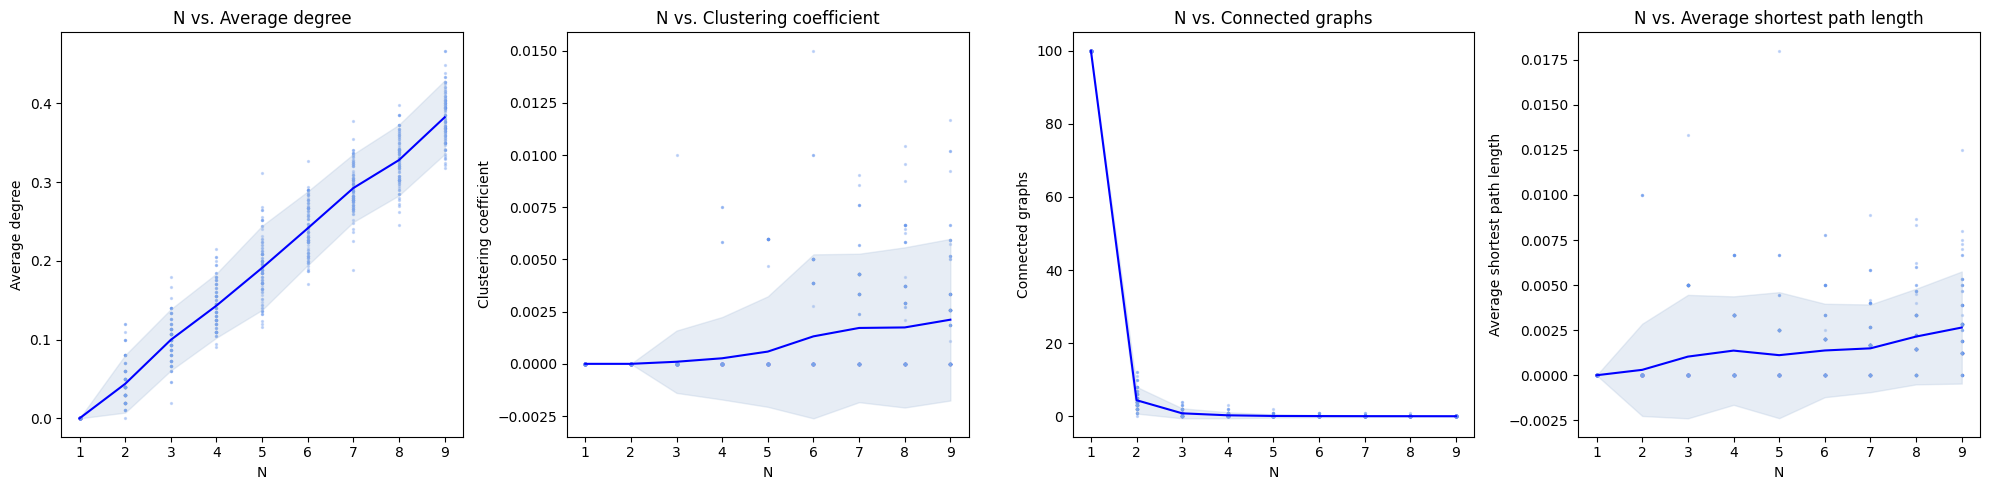

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

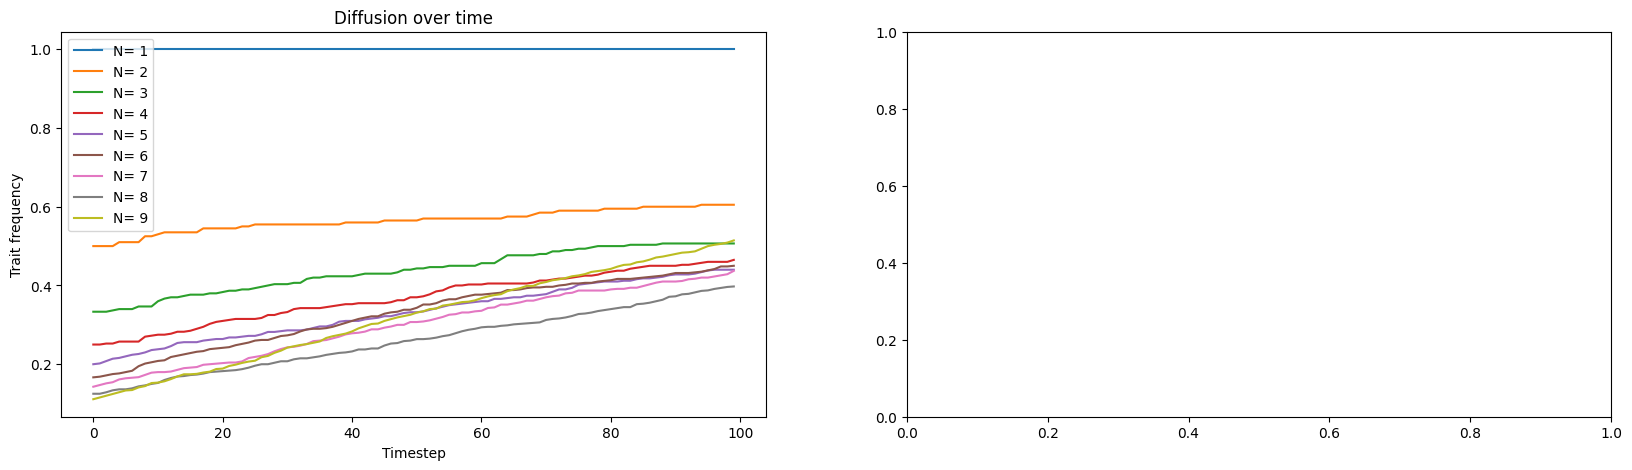

In [ ]:
summary_and_plot(dataN,'Average network properties of communication and transmission graphs under varying population size','N',list(range(1,10)))

In [ ]:
datag = run_simulation(100,2,10,10,100,0.05,1,2)

<ipython-input-4-2588cf4b5eb6>:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  orderlist = random.sample(G.nodes,len(G.nodes))


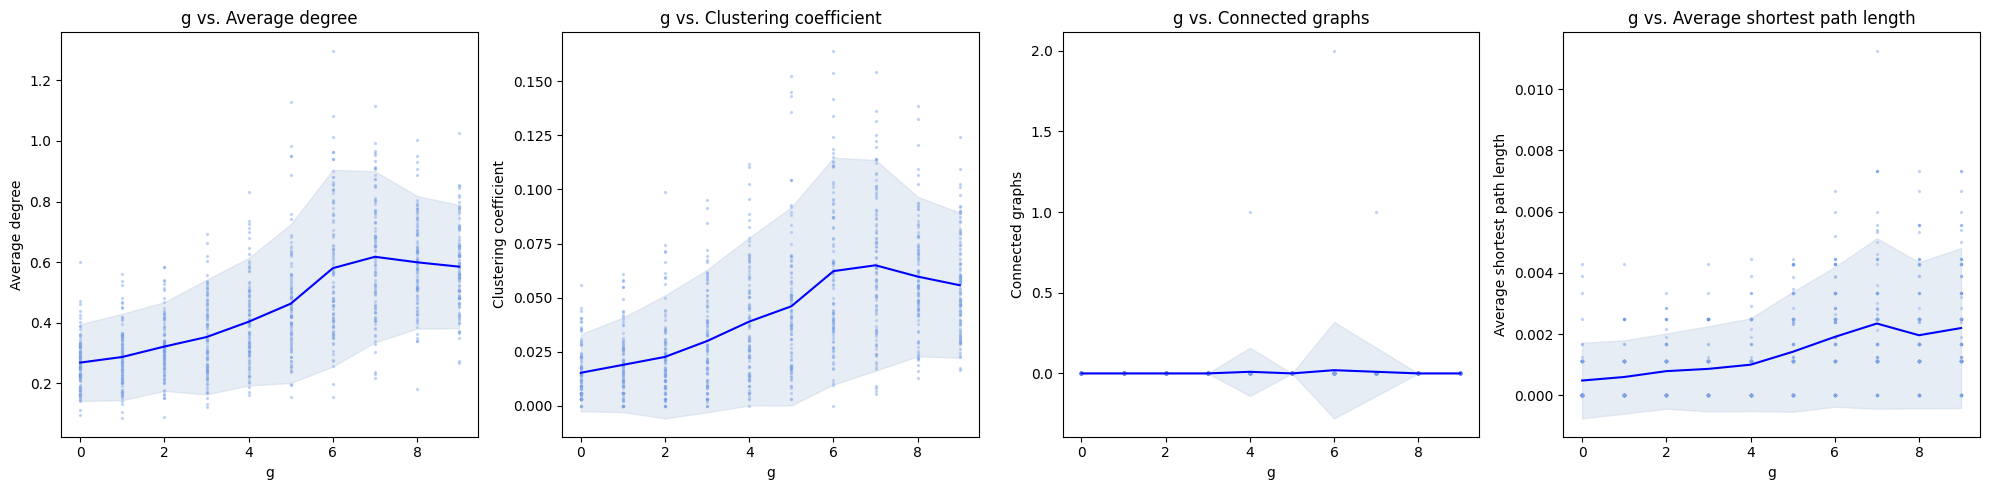

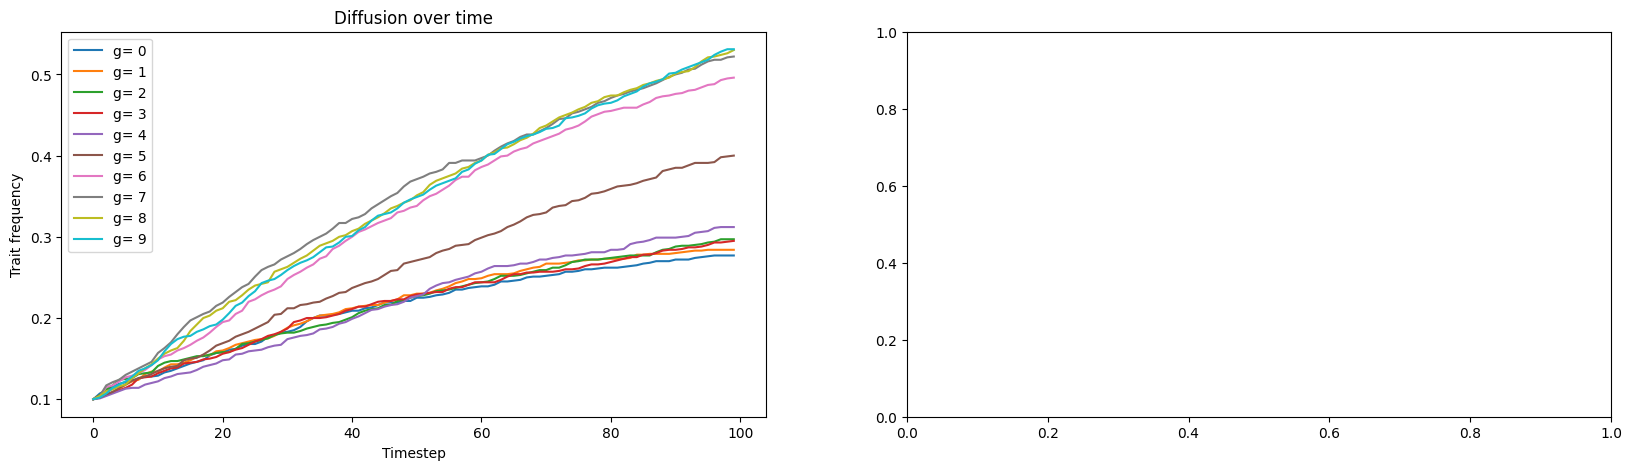

In [ ]:
summary_and_plot(datag,'Average network properties of communication and transmission graphs under varying environment size','g',list(range(10)),False)

In [ ]:
dataP = run_simulation(100,2,10,10,100,0.1,1,3)

<ipython-input-4-2588cf4b5eb6>:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  orderlist = random.sample(G.nodes,len(G.nodes))
<ipython-input-5-86718ab6ba21>:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  orderlist = random.sample(G_null.nodes,len(G_null.nodes))


In [ ]:
summary_and_plot(dataP,'Average network properties of communication and transmission graphs under varying infection rate','P',list(np.round(np.linspace(0,1,11),1)))